In [1]:
import qgrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
import h5py

### hapROH imports
#sys.path.insert(0,"/n/groups/reich/hringbauer/git/HAPSBURG/package/")  # hack to get development package first in path
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/hapBLOCK/IO/")  # hack to get development package first in path
from h5_load import get_coverage,get_genos_pairs,get_idx_iid,get_markers_good

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else:
    raise RuntimeWarning("No compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0, path)

compute-a-16-46.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


In [8]:
def opp_homos(g1, g2):
    """Return opposing homozygotes"""
    o1 = (g1 == 0) & (g2 == 2)
    o2 = (g1 == 2) & (g2 == 0)
    return (o1 | o2)

def return_phase_het_homo(f, sample1, sample2, cutoff=0.95,
                          output=True):
    """return phase of het/homo states, on markers of joint 
    quality cutoff"""
    
    g1, g2, m = get_genos_pairs(f, sample1=sample1, sample2=sample2, 
                            cutoff=cutoff, output=False, phased=True)

    idx_m = (m>0)
    g1 = g1[idx_m]
    g2 = g2[idx_m]
    m = m[idx_m]

    oh = opp_homos(np.sum(g1,axis=1), np.sum(g2, axis=1))
    idx_het = (np.sum(g1, axis=1) == 1) & (np.sum(g2, axis=1) != 1)
    if output:
        print(f"Markers loaded: {np.sum(idx_m)}")
        print(f"Opposing Homozygotes: {np.sum(oh)}")
        print(f"Het Markers loaded: {np.sum(idx_het)}")
    g1,g2,m = g1[idx_het], g2[idx_het], m[idx_het]
    f1 = g1[:,0] == g2[:,0]
    return m,f1

def plot_opp_hets(m, f1, c="slateblue", s=10, alpha=0.8, xlim=[20,80], 
                  figsize=(10,1.5), savepath="", dpi=300):
    """Plot opposing Homozygotes"""
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.scatter(m*100, f1, c=c, s=s, alpha=alpha)
    ax.set_yticks((0,1))
    ax.set_xlabel("centimorgan")
    ax.set_title("Phase of Hets Ind 1 copying from Ind 2 Homo")
    ax.set_xlim(xlim)
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    plt.show()
    
def print_switch_errors(m, f1):
    """Print switch error rates"""
    
    switch_errors = np.sum(np.diff(f1)) / ((np.max(m) - np.min(m)) * 100)
    print(f"Switch errors per cM: {switch_errors:.4f}")

    switch_errors = np.mean(np.diff(f1))
    print(f"Switch errors per het: {switch_errors:.4f}")

In [6]:
f.close()

In [3]:
f = h5py.File("./data/hdf5/1240k_v43/ch2.h5", "r") # Load for Sanity Check. See below!

j1 = get_idx_iid(f, "SUC002")
print(get_coverage(f, j1))
j2 = get_idx_iid(f, "SUC003")
print(get_coverage(f, j2))

1.2799528527284891
1.3732917078143416


In [4]:
%%time
g1, g2, m = get_genos_pairs(f, sample1="SUC002", sample2="SUC003", 
                            cutoff=0.95, output=True, phased=True)

idx_m = (m>0)
print(f"Markers loaded: {np.sum(idx_m)}")
g1 = g1[idx_m]
g2 = g2[idx_m]
m = m[idx_m]

oh = opp_homos(np.sum(g1,axis=1), np.sum(g2, axis=1))
print(f"Opposing Homozygotes: {np.sum(oh)}")

idx_het = (np.sum(g1, axis=1) == 1) & (np.sum(g2, axis=1) != 1)
print(f"Het Markers loaded: {np.sum(idx_het)}")
g1,g2,m = g1[idx_het], g2[idx_het], m[idx_het]

f1 = g1[:,0] == g2[:,0]
f2 = g1[:,1] == g2[:,0]

Filtering to 0.95 GP variants: 0.892x
Filtering to 0.95 GP variants: 0.911x
Filtering to common GP variants: 0.836x
Markers loaded: 78753
Opposing Homozygotes: 2
Het Markers loaded: 8994
CPU times: user 462 ms, sys: 28 ms, total: 490 ms
Wall time: 1.19 s


### Sardinia Pair

Markers loaded: 42511
Opposing Homozygotes: 1
Het Markers loaded: 4483


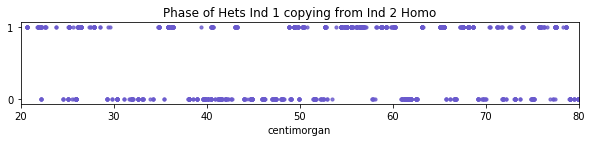

Switch errors per cM: 0.9127
Switch errors per het: 0.0544


In [26]:
m,f1 = return_phase_het_homo(f, sample1="SUC002", sample2="SUC003")
plot_opp_hets(m, f1)
print_switch_errors(m,f1, savepath="/")

### What happens if one makes error and adds brothers

Markers loaded: 44837
Opposing Homozygotes: 612
Het Markers loaded: 3967


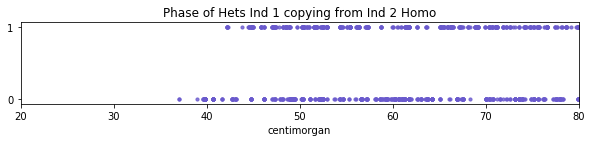

Switch errors per cM: 1.9607
Switch errors per het: 0.1301


In [49]:
m,f1 = return_phase_het_homo(f, sample1="COR001", sample2="COR002")
plot_opp_hets(m, f1)
print_switch_errors(m,f1)

### Bell Beaker Pair

Markers loaded: 85135
Opposing Homozygotes: 3
Het Markers loaded: 9648
Saved to ./figs/dumpster/for_23/phasing_hets.png


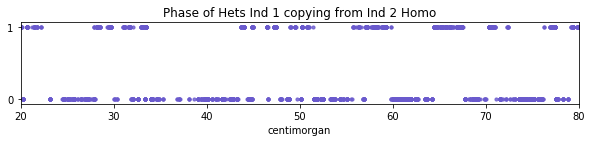

Switch errors per cM: 0.8051
Switch errors per het: 0.0223
CPU times: user 1.15 s, sys: 40.5 ms, total: 1.19 s
Wall time: 1.16 s


In [9]:
%%time
m,f1 = return_phase_het_homo(f, sample1="I7282", sample2="I7283", cutoff=0.95)
plot_opp_hets(m, f1, savepath="./figs/dumpster/for_23/phasing_hets.png")
print_switch_errors(m,f1)

### Afanisievo Pair

Markers loaded: 45189
Opposing Homozygotes: 3
Het Markers loaded: 4860


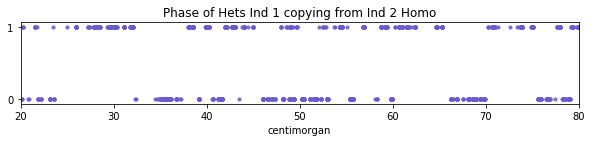

Switch errors per cM: 0.6846
Switch errors per het: 0.0377
CPU times: user 736 ms, sys: 75.1 ms, total: 811 ms
Wall time: 1.03 s


In [30]:
%%time
m,f1 = return_phase_het_homo(f, sample1="10565", sample2="I6712", cutoff=0.95)
plot_opp_hets(m, f1)
print_switch_errors(m,f1)

### Chinese Pair

Markers loaded: 46754
Opposing Homozygotes: 1
Het Markers loaded: 4825


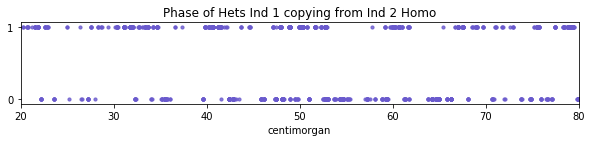

Switch errors per cM: 1.0595
Switch errors per het: 0.0589
CPU times: user 691 ms, sys: 62.9 ms, total: 754 ms
Wall time: 748 ms


In [36]:
%%time
m,f1 = return_phase_het_homo(f, sample1="LJM3", sample2="LJM5", cutoff=0.95)
plot_opp_hets(m, f1)
print_switch_errors(m,f1)

# Roman Mesolithic Pair

Markers loaded: 46731
Opposing Homozygotes: 5
Het Markers loaded: 5030


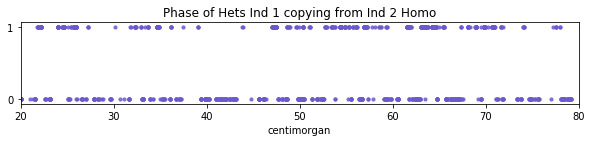

Switch errors per cM: 1.0430
Switch errors per het: 0.0555
CPU times: user 704 ms, sys: 65.8 ms, total: 770 ms
Wall time: 765 ms


In [39]:
%%time
m,f1 = return_phase_het_homo(f, sample1="I10467", sample2="I10475.SG", cutoff=0.95)
plot_opp_hets(m, f1)
print_switch_errors(m,f1)

### Run Caribbean Pair

Markers loaded: 43492
Opposing Homozygotes: 2
Het Markers loaded: 3758


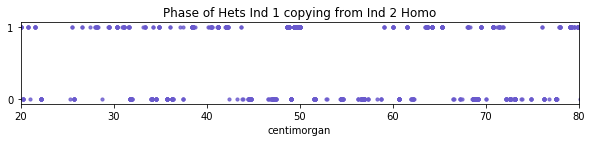

Switch errors per cM: 0.7220
Switch errors per het: 0.0514
CPU times: user 694 ms, sys: 63.6 ms, total: 758 ms
Wall time: 752 ms


In [52]:
%%time
m,f1 = return_phase_het_homo(f, sample1="I17903", sample2="I17906", cutoff=0.95)
plot_opp_hets(m, f1)
print_switch_errors(m,f1)